# Interpretable Modelling of Credit Risk

As detailed in Cynthia Rudin's excellent commentary on interpretability [(ArXiV version here)](https://arxiv.org/abs/1811.10154), there are a plethora of reasons to avoid the use of black box models when models are being used to make high stakes decisions to may have life-altering effects on real people. Efforts to develop "explainable black box models," while appealing for their potential to let us continuing using the same tools we always have and to creation explanations after the fact, are inherently flawed. As Rudin notes in my single favorite passage from her paper:

> Explainable ML methods provide explanations that are not faithful to what the original model computes. Explanations must be wrong. They cannot have perfect fidelity with respect to the original model. If the explanation was completely faithful to what the original model computes, the explanation would equal the original model, and one would not need the original model in the first place, only the explanation. (In other words, this is a case where the original model would be interpretable.) This leads to the danger that any explanation method for a black box model can be an inaccurate representation of the original model in parts of the feature space.
>
> An inaccurate (low-fidelity) explanation model limits trust in the explanation, and by extension, trust in the black box that it is trying to explain. An explainable model that has a 90% agreement with the original model indeed explains the original model most of the time. However, an explanation model that is correct 90% of the time is wrong 10% of the time. If a tenth of the explanations are incorrect, one cannot trust the explanations, and thus one cannot trust the original black box. If we cannot know for certain whether our explanation is correct, we cannot know whether to trust either the explanation or the original model.

With this motivation in mind, in this exercise, we will use a cutting edge interpretable modeling framework to model credit risk using data from the [14th Pacific-Asia Knowledge Discovery and Data Mining conference (PAKDD 2010)](https://pakdd.org/archive/pakdd2010/). This data covers the period of 2006 to 2009, and "comes from a private label credit card operation of a Brazilian credit company and its partner shops." (The competition was won by [TIMi](https://timi.eu/blog/news/timi-top-winner-at-the-pakdd-2010-cup/), who purely by coincidence helped me complete my PhD dissertation research!).

We will be working with Generalized Additive Models (GAMs) (not to be confused with Generalized *Linear* Models (GLMs) — GLMs are a special case of GAMs). In particular, we will be using the [pyGAM](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html), though this is far from the only GAM implementation out there. [mvgam](https://nicholasjclark.github.io/mvgam/) in R is probably considered the gold standard, as it was developed by a pioneering researcher of GAMs. `statsmodels` also has [an implementation](https://www.statsmodels.org/stable/gam.html), and GAM is also hiding in plain sight behind many other tools, like Meta's [Prophet](https://facebook.github.io/prophet/) time series forecasting library (which is GAM-based).

## Data Prep

### Exercise 1

The PADD 2010 data is in [this repository](https://github.com/nickeubank/MIDS_Data/tree/master/PAKDD%202010). You can find column names in `PAKDD2010_VariablesList.XLS` and the actual data in `PAKDD2010_Modeling_Data.txt`.

Note: you may run into a string-encoding issue loading the `PAKDD2010_Modeling_Data.txt` data. All I'll say is that most latin-based languages used `latin8` as a text encoding prior to broad adoption of UTF-8. (Don't know about UTF? [Check out this video](https://www.youtube.com/watch?v=MijmeoH9LT4)!)

Load the data (including column names).

In [1]:
import pandas as pd

col_n = [
    "ID_CLIENT",
    "CLERK_TYPE",
    "PAYMENT_DAY",
    "APPLICATION_SUBMISSION_TYPE",
    "QUANT_ADDITIONAL_CARDS",
    "POSTAL_ADDRESS_TYPE",
    "SEX",
    "MARITAL_STATUS",
    "QUANT_DEPENDANTS",
    "EDUCATION_LEVEL",
    "STATE_OF_BIRTH",
    "CITY_OF_BIRTH",
    "NACIONALITY",
    "RESIDENCIAL_STATE",
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "FLAG_RESIDENCIAL_PHONE",
    "RESIDENCIAL_PHONE_AREA_CODE",
    "RESIDENCE_TYPE",
    "MONTHS_IN_RESIDENCE",
    "FLAG_MOBILE_PHONE",
    "FLAG_EMAIL",
    "PERSONAL_MONTHLY_INCOME",
    "OTHER_INCOMES",
    "FLAG_VISA",
    "FLAG_MASTERCARD",
    "FLAG_DINERS",
    "FLAG_AMERICAN_EXPRESS",
    "FLAG_OTHER_CARDS",
    "QUANT_BANKING_ACCOUNTS",
    "QUANT_SPECIAL_BANKING_ACCOUNTS",
    "PERSONAL_ASSETS_VALUE",
    "QUANT_CARS",
    "COMPANY",
    "PROFESSIONAL_STATE",
    "PROFESSIONAL_CITY",
    "PROFESSIONAL_BOROUGH",
    "FLAG_PROFESSIONAL_PHONE",
    "PROFESSIONAL_PHONE_AREA_CODE",
    "MONTHS_IN_THE_JOB",
    "PROFESSION_CODE",
    "OCCUPATION_TYPE",
    "MATE_PROFESSION_CODE",
    "EDUCATION_LEVEL_MATE",
    "FLAG_HOME_ADDRESS_DOCUMENT",
    "FLAG_RG",
    "FLAG_CPF",
    "FLAG_INCOME_PROOF",
    "PRODUCT",
    "FLAG_ACSP_RECORD",
    "AGE",
    "RESIDENCIAL_ZIP_3",
    "PROFESSIONAL_ZIP_3",
    "TARGET_LABEL_BAD=1",
]


padd_2010 = pd.read_csv(
    "https://github.com/nickeubank/MIDS_Data/raw/master/PAKDD%202010/PAKDD2010_Modeling_Data.txt",
    encoding="latin8",
    sep="\t",
    header=None,
    names=col_n,
    index_col=None,
    dtype={"RESIDENCIAL_ZIP_3": str, "PROFESSIONAL_ZIP_3": str},
)

### Exercise 2

There are a few variables with a lot of missing values (more than half missing). Given the limited documentation for this data it's a little hard to be sure why, but given the effect on sample size and what variables are missing, let's go ahead and drop them. You you end up dropping 6 variables.

Hint: Some variables have missing values that aren't immediately obviously.

(This is not strictly necessary at this stage, given we'll be doing more feature selection down the line, but keeps things easier knowing we don't have to worry about missingness later.)

In [2]:
padd_2010.isnull().sum()

ID_CLIENT                             0
CLERK_TYPE                            0
PAYMENT_DAY                           0
APPLICATION_SUBMISSION_TYPE           0
QUANT_ADDITIONAL_CARDS                0
POSTAL_ADDRESS_TYPE                   0
SEX                                   0
MARITAL_STATUS                        0
QUANT_DEPENDANTS                      0
EDUCATION_LEVEL                       0
STATE_OF_BIRTH                        0
CITY_OF_BIRTH                         0
NACIONALITY                           0
RESIDENCIAL_STATE                     0
RESIDENCIAL_CITY                      0
RESIDENCIAL_BOROUGH                   0
FLAG_RESIDENCIAL_PHONE                0
RESIDENCIAL_PHONE_AREA_CODE           0
RESIDENCE_TYPE                     1349
MONTHS_IN_RESIDENCE                3777
FLAG_MOBILE_PHONE                     0
FLAG_EMAIL                            0
PERSONAL_MONTHLY_INCOME               0
OTHER_INCOMES                         0
FLAG_VISA                             0


In [3]:
for column in padd_2010:
    print(f"Value counts for {column}:")
    print(padd_2010[column].value_counts())
    print("\n")

Value counts for ID_CLIENT:
ID_CLIENT
1        1
33351    1
33329    1
33330    1
33331    1
        ..
16669    1
16670    1
16671    1
16672    1
50000    1
Name: count, Length: 50000, dtype: int64


Value counts for CLERK_TYPE:
CLERK_TYPE
C    50000
Name: count, dtype: int64


Value counts for PAYMENT_DAY:
PAYMENT_DAY
10    20422
15     8750
5      7347
25     7026
20     4694
1      1761
Name: count, dtype: int64


Value counts for APPLICATION_SUBMISSION_TYPE:
APPLICATION_SUBMISSION_TYPE
Web      28206
0        19461
Carga     2333
Name: count, dtype: int64


Value counts for QUANT_ADDITIONAL_CARDS:
QUANT_ADDITIONAL_CARDS
0    50000
Name: count, dtype: int64


Value counts for POSTAL_ADDRESS_TYPE:
POSTAL_ADDRESS_TYPE
1    49673
2      327
Name: count, dtype: int64


Value counts for SEX:
SEX
F    30805
M    19130
N       48
        17
Name: count, dtype: int64


Value counts for MARITAL_STATUS:
MARITAL_STATUS
2    25967
1    15286
4     4206
6     1877
5     1296
3      632
7      

In [4]:
padd_2010_2 = padd_2010.drop(
    columns=[
        "PROFESSIONAL_CITY",
        "PROFESSIONAL_BOROUGH",
        "MATE_PROFESSION_CODE",
        "EDUCATION_LEVEL_MATE",
        "EDUCATION_LEVEL",
        "PROFESSIONAL_STATE",
        "PROFESSIONAL_PHONE_AREA_CODE",
    ]
)

In [5]:
padd_2010_2

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,STATE_OF_BIRTH,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,C,5,Web,0,1,F,6,1,RN,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,RJ,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,RN,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,PE,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,RJ,...,0,0,0,0,1,N,48,235,235,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996,C,10,0,0,1,F,1,2,RN,...,0,0,0,0,1,N,36,591,591,1
49996,49997,C,25,0,0,1,F,1,0,SP,...,0,0,0,0,2,N,21,186,186,0
49997,49998,C,5,Web,0,1,M,2,3,PR,...,0,0,0,0,1,N,41,715,715,0
49998,49999,C,1,Web,0,1,F,1,1,SP,...,0,0,0,0,1,N,28,320,320,1


### Exercise 3

Let's start off by fitting a model that uses the following variables:

```
"QUANT_DEPENDANTS",
"QUANT_CARS",
"MONTHS_IN_RESIDENCE",
"PERSONAL_MONTHLY_INCOME",
"QUANT_BANKING_ACCOUNTS",
"AGE",
"SEX",
"MARITAL_STATUS",
"OCCUPATION_TYPE",
"RESIDENCE_TYPE",
"RESIDENCIAL_STATE",
"RESIDENCIAL_CITY",
"RESIDENCIAL_BOROUGH",
"RESIDENCIAL_ZIP_3"
```

(GAMs don't have any automatic feature selection methods, so these are based on my own sense of features that are likely to matter. A fully analysis would entail a few passes at feature refinement)

Plot and otherwise characterize the distributions of all the variables we may use. If you see anything bananas, adjust how terms enter your model. Yes, pyGAM has flexible functional forms, but giving the model features that are engineered to be more substantively meaningful (e.g., taking log of income) will aid model estimation. 

You should probably do something about the functional form of *at least* `PERSONAL_MONTHLY_INCOME`, and `QUANT_DEPENDANTS`.

In [6]:
import numpy as np

model_1 = padd_2010_2[
    [
        "QUANT_DEPENDANTS",
        "QUANT_CARS",
        "MONTHS_IN_RESIDENCE",
        "PERSONAL_MONTHLY_INCOME",
        "QUANT_BANKING_ACCOUNTS",
        "AGE",
        "SEX",
        "MARITAL_STATUS",
        "OCCUPATION_TYPE",
        "RESIDENCE_TYPE",
        "RESIDENCIAL_STATE",
        "RESIDENCIAL_CITY",
        "RESIDENCIAL_BOROUGH",
        "RESIDENCIAL_ZIP_3",
    ]
].copy()

qual_vars = [
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "RESIDENCIAL_STATE",
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "RESIDENCIAL_ZIP_3",
]
quant_vars = [
    "QUANT_DEPENDANTS",
    "QUANT_CARS",
    "MONTHS_IN_RESIDENCE",
    "PERSONAL_MONTHLY_INCOME",
    "QUANT_BANKING_ACCOUNTS",
    "AGE",
]
# Convert columns to string type
model_1[qual_vars] = model_1[qual_vars].astype(str)
model_1["PERSONAL_MONTHLY_INCOME"] = np.log(model_1["PERSONAL_MONTHLY_INCOME"])

In [7]:
model_1.describe()

,QUANT_DEPENDANTS,QUANT_CARS,MONTHS_IN_RESIDENCE,PERSONAL_MONTHLY_INCOME,QUANT_BANKING_ACCOUNTS,AGE
count,50000.000000,50000.000000,46223.000000,50000.000000,50000.000000,50000.00000
mean,0.650520,0.336140,9.727149,6.358338,0.357840,43.24852
std,1.193655,0.472392,10.668841,0.619500,0.479953,14.98905
min,0.000000,0.000000,0.000000,4.094345,0.000000,6.00000
25%,0.000000,0.000000,1.000000,5.886104,0.000000,31.00000
50%,0.000000,0.000000,6.000000,6.214608,0.000000,41.00000
75%,1.000000,1.000000,15.000000,6.684612,1.000000,53.00000
max,53.000000,1.000000,228.000000,13.773646,2.000000,106.00000


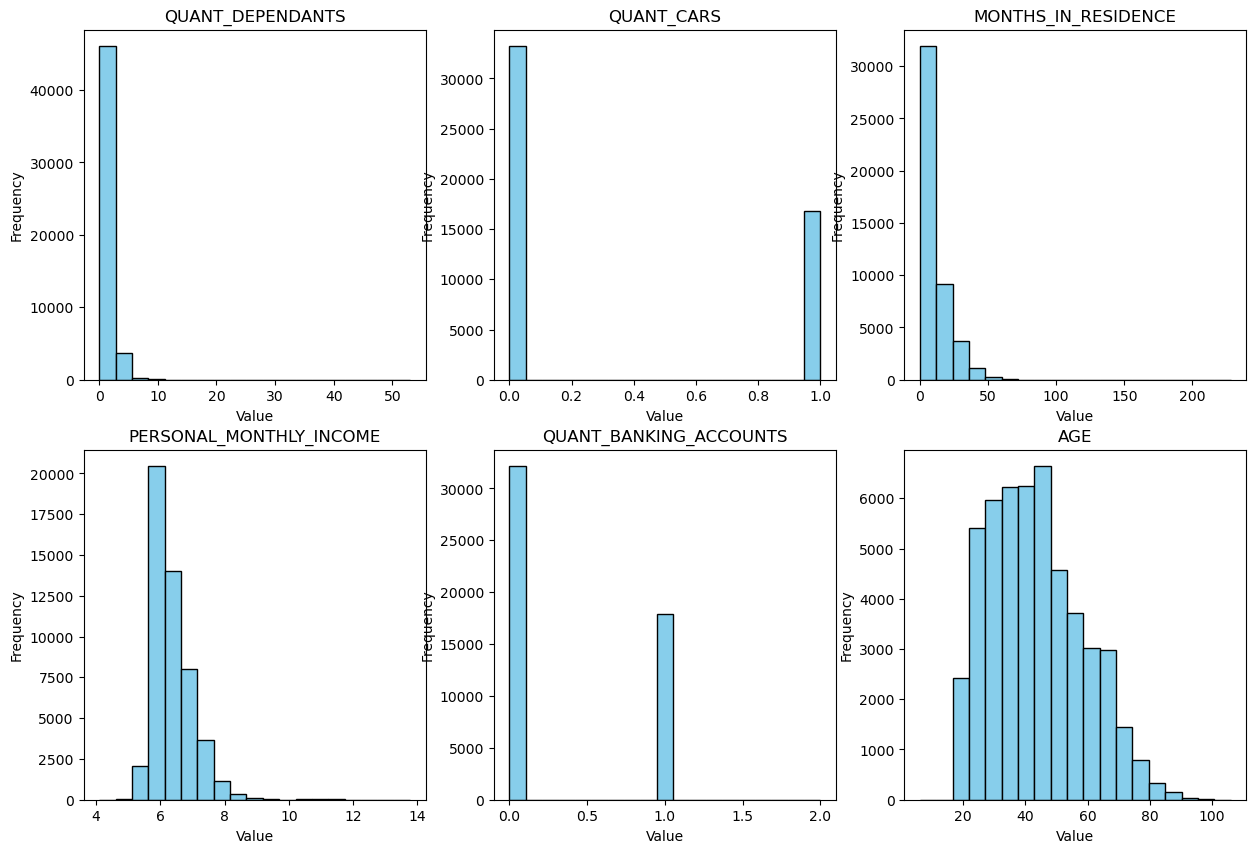

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define the columns for the histograms


fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each column
for i, column in enumerate(quant_vars):
    ax = axes[i]
    ax.hist(
        model_1[column],
        bins=np.linspace(model_1[column].min(), model_1[column].max(), 20),
        color="skyblue",
        edgecolor="black",
    )
    ax.set_title(column)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

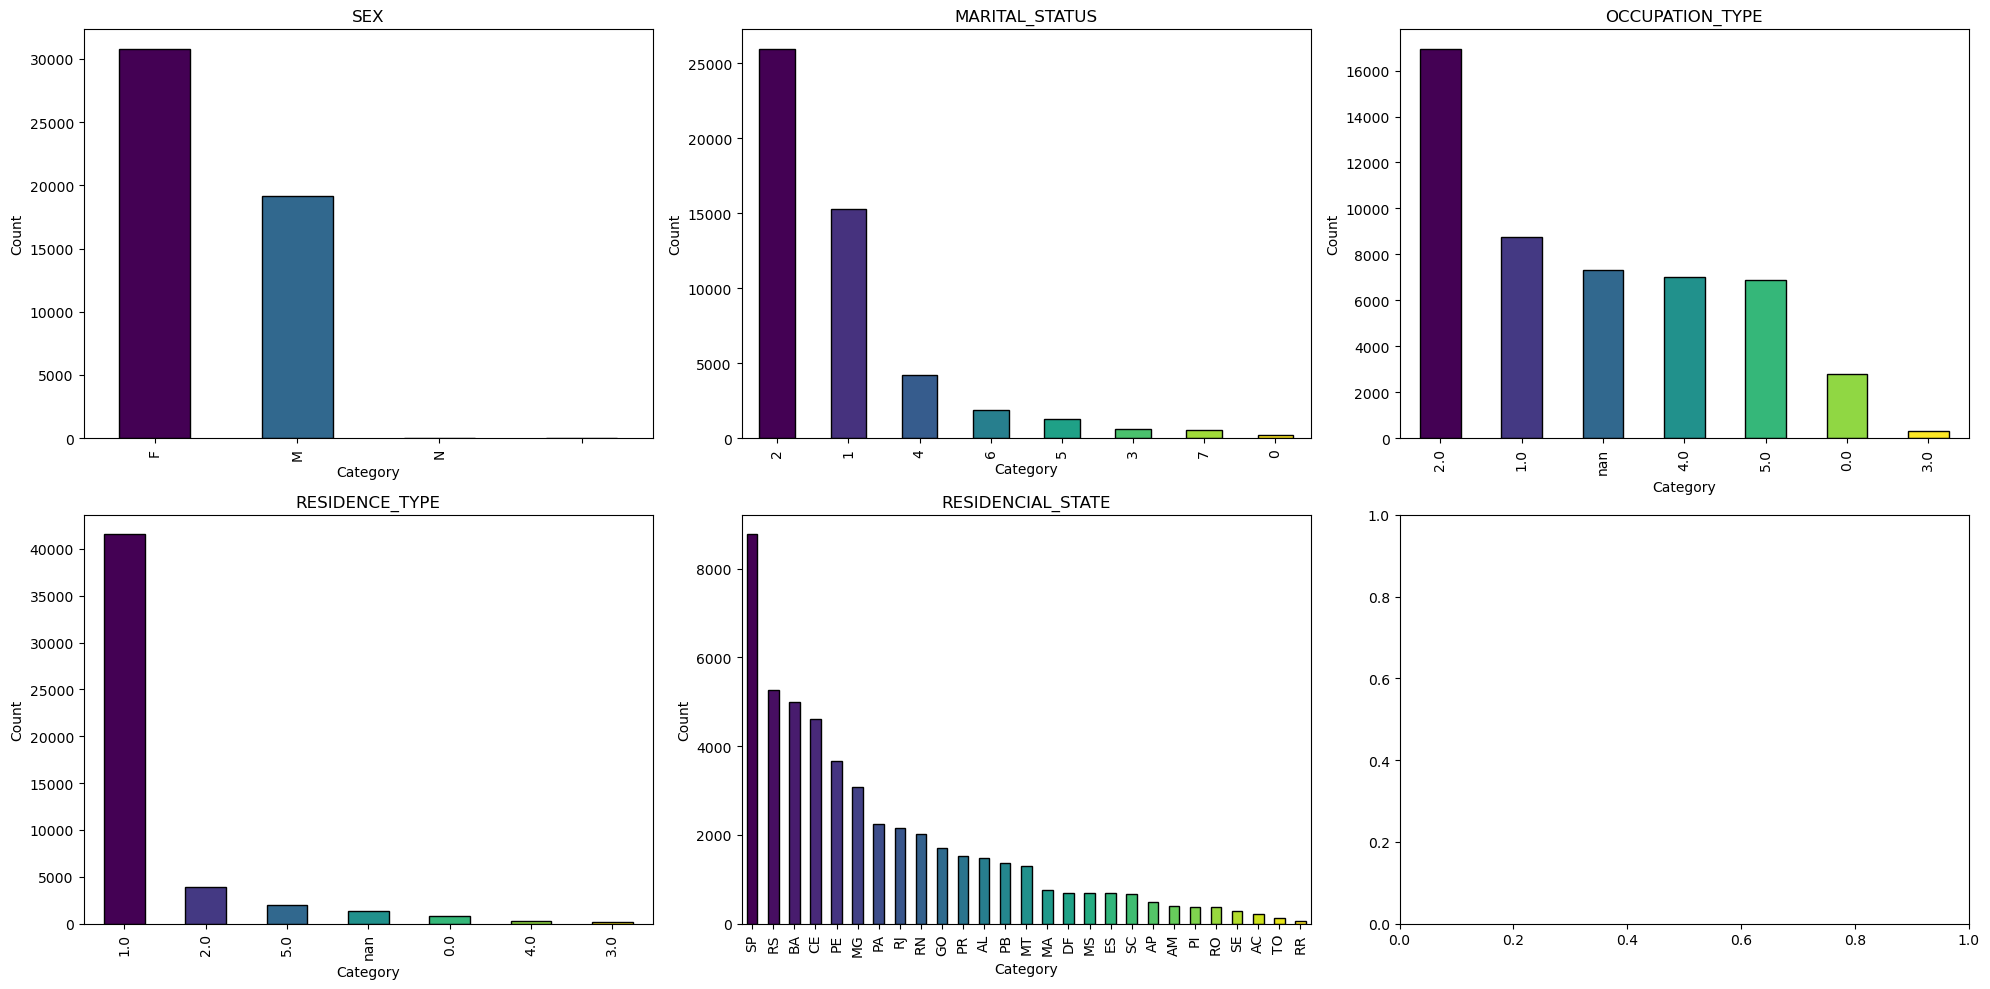

In [9]:
import matplotlib.pyplot as plt
import numpy as np

qual_vars2 = [
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "RESIDENCIAL_STATE",
]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

axes = axes.flatten()

cmap = plt.get_cmap("viridis")

for i, var in enumerate(qual_vars2):
    ax = axes[i]
    var_counts = model_1[var].value_counts()
    categories = var_counts.index
    colors = cmap(np.linspace(0, 1, len(categories)))

    var_counts.plot(kind="bar", ax=ax, color=colors, edgecolor="black")
    ax.set_title(var)
    ax.set_xlabel("Category")
    ax.set_ylabel("Count")

plt.tight_layout()

plt.show()

### Exercise 4

Geographic segregation means residency data often contains LOTS of information. But there's a problem with `RESIDENCIAL_CITY` and `RESIDENCIAL_BOROUGH`. What is the problem?

In any real project, this would be something absolutely worth resolving, but for this exercise, we'll just drop all three string `RESIDENCIAL_` variables.

In [10]:
for column_name in qual_vars:
    total_unique = model_1[column_name].nunique()
    print(
        f"Total number of unique observations in the '{column_name}' variable:",
        total_unique,
    )

Total number of unique observations in the 'SEX' variable: 4
Total number of unique observations in the 'MARITAL_STATUS' variable: 8
Total number of unique observations in the 'OCCUPATION_TYPE' variable: 7
Total number of unique observations in the 'RESIDENCE_TYPE' variable: 7
Total number of unique observations in the 'RESIDENCIAL_STATE' variable: 27
Total number of unique observations in the 'RESIDENCIAL_CITY' variable: 3529
Total number of unique observations in the 'RESIDENCIAL_BOROUGH' variable: 14511
Total number of unique observations in the 'RESIDENCIAL_ZIP_3' variable: 794


In [11]:
model_1 = model_1.drop(
    columns=["RESIDENCIAL_CITY", "RESIDENCIAL_BOROUGH", "RESIDENCIAL_STATE"]
)

The total number of unique observations in the 'RESIDENCIAL_CITY' is 3529, and for 'RESIDENCIAL_BOROUGH' is 14511. By doing a review of these unique values, we can see that most of them point to the same borough but with different spelling, use of caps and use of complete name. These lack of consistency on spelling results in different observations in the dataset that refer to the same city or borough. 

## Model Fitting

### Exercise 5

First, use `train_test_split` to do an 80/20 split of your data. Then, using the `TARGET_LABEL_BAD` variable, fit a classification model on this data. Optimize with `gridsearch`. Use splines for continuous variables and factors for categoricals.

At this point we'd *ideally* be working with 11 variables. However pyGAM can get a little slow with factor features with lots of values + lots of unique values (e.g., 50,000 observations and the *many* values of `RESIDENCIAL_ZIP` takes about 15 minutes on my computer). In that configuration, you should get a model fit in 10-15 seconds.

So let's start by fitting a model that also excludes `RESIDENCIAL_ZIP`.

In [12]:
# model_1.columns

model_1 = model_1.drop(columns=["RESIDENCIAL_ZIP_3"])

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    model_1, padd_2010["TARGET_LABEL_BAD=1"], test_size=0.2, random_state=42
)

In [14]:
y_train

39087    1
30893    0
45278    0
16398    0
13653    0
        ..
11284    0
44732    0
38158    0
860      0
15795    0
Name: TARGET_LABEL_BAD=1, Length: 40000, dtype: int64

### Exercise 6

Create a (naive) confusion matrix using the predicted values you get with `predict()` on your test data. Our stakeholder cares about two things: 

- maximizing the number of people to whom they extend credit, and
- the false negative rate (the share of people identified as "safe bets" who aren't, and who thus default).

How many "good bets" does the model predict (true negatives), and what is the [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives)?

Looking at the confusion matrix, how did the model maximize accuracy?

### Exercise 7

Suppose your stakeholder wants to minimize false negative rates. How low of a [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives) can you get (assuming more than, say, 10 true negatives), and how many "good bets" (true negatives) do they get at that risk level?

Hint: use `predict_proba()`

Note: One *can* use class weights to shift the emphasis of the original model fitting, but for the moment let's just play with `predict_proba()` and thresholds.

### Exercise 8

If the stakeholder wants to maximize true negatives and can tolerate a false omission rate of 19%, how many true negatives will they be able to enroll?

## Let's See This Interpretability!

We're using GAMs for their interpretability, so let's use it!

### Exercise 9


Plot the partial dependence plots for all your continuous factors with 95% confidence intervals (I have three, at this stage).

If you get an error like this when generating `partial_dependence` errors:

```python
----> pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

...
ValueError: X data is out of domain for categorical feature 4. Expected data on [1.0, 2.0], but found data on [0.0, 0.0]
```

it's because you have a variable set as a factor that doesn't have values of `0`. pyGAM is assuming `0` is the excluded category. Just recode the variable to ensure 0 is used to identify one of the categories.

### Exercise 10

How does the partial correlation with respect to age look?

### Exercise 11

Refit your model, but this time impose [monotonicity or concavity/convexity](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Penalties-/-Constraints) on the relationship between age and credit risk (which makes more sense to you?). Fit the model and plot the new partial dependence.

### Exercise 12

Functional form constraints are often about fairness or meeting regulatory requirements, but they can also prevent overfitting.

Does this change the number of "true negatives" you can enroll below a false omission rate of 19%?

### Exercise 13

In the preceding exercises, we allowed pyGAM to choose its own smoothing parameters / coefficient penalties. This makes life easy, but it isn't always optimal, especially because when it does so, it picks the same smoothing penalty (the `lambda` in `.summary()`) for all terms.

(If you haven't seen them let, penalities are designed to limit overfitting by, basically, "penalizing" big coefficients on different terms. This tends to push models towards smoother fits.)

[To get around this, we can do a grid or random search.](https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html#Automatically-tune-the-model) This is definitely a little slow, but let's give it a try!

Then following the model given in the docs linked above, let's do a random search. Make sure your initial random points has a shape of `100 x (the number of terms in your model)`.

### Exercise 14

How many true negatives can you get now at a less than 19% False Omission Rate?

### Exercise 15

Add an interaction term between age and personal income.

### Exercise 16

Now visualize the [partial dependence interaction term.](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Terms-and-Interactions)

### Exercise 17

Finally, another popular interpretable model is the `ExplainableBoostingClassifier`. You can learn more [about it here](https://interpret.ml/docs/ebm.html), though how much sense it will make to you may be limited if you aren't familiar with gradient boosting yet. Still, at least one of your classmates prefers it to pyGAM, so give it a try using this code:


```python
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import warnings

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

with warnings.catch_warnings():
   warnings.simplefilter("ignore")

   ebm_global = ebm.explain_global()
   show(ebm_global)

   ebm_local = ebm.explain_local(X_train, y_train)
   show(ebm_local)
```